# Self made SVD

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVD():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [3]:
model=SVD(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.7486867798606991. Training epoch 40...: 100%|██████████| 40/40 [02:44<00:00,  4.12s/it]


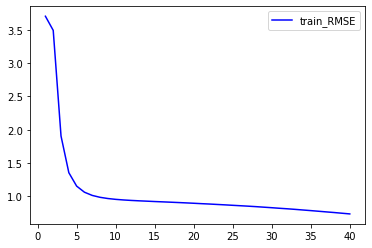

In [4]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process).iloc[:,:2]
df.columns=['epoch', 'train_RMSE']
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.legend()

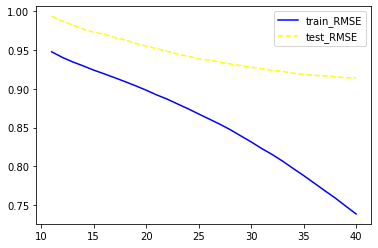

In [5]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process[10:], columns=['epoch', 'train_RMSE', 'test_RMSE'])
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.plot('epoch', 'test_RMSE', data=df, color='yellow', linestyle='dashed')
plt.legend()

#### Saving and evaluating recommendations

In [6]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVD_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', index=False, header=False)

In [7]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVD_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 4196.25it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  0.914024  0.717181   0.104454  0.043836  0.053331  0.070716   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.094528      0.076751  0.106711  0.050532  0.194366  0.518647   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.479321  0.045941       0.153261      0.853765       0.148629  3.836334   

       Gini  
0  0.973007

In [8]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 4120.95it/s]
943it [00:00, 4286.76it/s]
943it [00:00, 4253.65it/s]
943it [00:00, 4386.02it/s]
943it [00:00, 4497.82it/s]
943it [00:00, 4289.74it/s]
943it [00:00, 4682.40it/s]
943it [00:00, 4255.79it/s]
943it [00:00, 3942.08it/s]
943it [00:00, 4136.45it/s]
943it [00:00, 3908.85it/s]
943it [00:00, 3779.61it/s]
943it [00:00, 4456.49it/s]
943it [00:00, 3504.99it/s]
943it [00:00, 3182.20it/s]
943it [00:00, 3850.55it/s]
943it [00:00, 3881.66it/s]
943it [00:00, 4822.70it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0          Self_RP3Beta  3.702928  3.527713   0.322694  0.216069  0.212152   
0               Self_P3  3.702446  3.527273   0.282185  0.192092  0.186749   
0           Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0      Self_SVDBaseline  3.645666  3.480246   0.137858  0.082398  0.084151   
0             Ready_SVD  0.952563  0.750158   0.094486  0.046274  0.051389   
0              Self_SVD  0.914024  0.717181   0.104454  0.043836  0.053331   
0        Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0  Self_KNNSurprisetask  0.946255  0.745209   0.083457  0.032848  0.041227   
0         Self_TopRated  2.508258  2.217909   0.079321  0.032667  0.039983   
0       Ready_SVDBiased  0.942141  0.742760   0.081230  0.032344  0.040302   
0        Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0          Ready_Random  1.525633  1.225714   0.047720  0.022049  0.025494   
0           Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0   Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0           Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0       Self_BaselineIU  0.958136  0.754051   0.000954  0.000188  0.000298   
0       Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0             Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.247538         0.245279      0.284983  0.388271  0.248239  0.636318   
0  0.216980         0.204185      0.240096  0.339114  0.204905  0.572157   
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.101063         0.107940      0.109393  0.164477  0.082973  0.342374   
0  0.065625         0.082618      0.074150  0.109320  0.051383  0.240693   
0  0.070716         0.094528      0.076751  0.106711  0.050532  0.194366   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.055493         0.074785      0.048890  0.089577  0.040902  0.189057   
0  0.053170         0.068884      0.048582  0.070766  0.027602  0.114790   
0  0.053932         0.072639      0.051126  0.087552  0.039346  0.191285   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.032845         0.029077      0.025015  0.051757  0.019242  0.128181   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       F_2  Whole_average  Reco in test  Test coverage  \
0  0.605683  0.910923  0.205450       0.376967      0.999788       0.178932   
0  0.593544  0.875928  0.181702       0.340803      1.000000       0.077201   
0  0.555546  0.765642  0.112750       0.249607      1.000000       0.038961   
0  0.538097  0.638388  0.079860       0.205748      0.999894       0.279221   
0  0.519849  0.475080  0.046237       0.154759      0.993425       0.206349   
0  0.518647  0.479321  0.045941       0.153261      0.853765       0.148629   
0  0.515501  0.437964  0.039549       0.141900      1.000000       0.033911   
0  0.513076  0.417815  0.034996       0.135177      0.888547       0.130592   
0  0.512943  0.411453  0.034385       0.124546      1.000000       0.024531   
0  0.512818  0.416755  0.034405       0.134478      0.997667       0.165224   
0  0.509546  0.384942  0.027213       0.118383      1.000000       0.025974   
0  0.507543  0.327678  0.022628       0.103269      0.987275       0.184704   
0  0.499885  0.154825  0.008007       0.069521      0.402333   

### Embeddings

In [9]:
x=np.array([[1,2],[3,4]])
display(x)
x/np.linalg.norm(x, axis=1)[:,None]

array([[1, 2],
       [3, 4]])

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [10]:
item=random.choice(list(set(train_ui.indices)))

embeddings_norm=model.Qi/np.linalg.norm(model.Qi, axis=1)[:,None] # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores=np.dot(embeddings_norm,embeddings_norm[item].T)
top_similar_items=pd.DataFrame(enumerate(similarity_scores), columns=['code', 'score'])\
.sort_values(by=['score'], ascending=[False])[:10]

top_similar_items['item_id']=top_similar_items['code'].apply(lambda x: item_code_id[x])

items=pd.read_csv('./Datasets/ml-100k/movies.csv')

result=pd.merge(top_similar_items, items, left_on='item_id', right_on='id')

result

code     score  item_id    id                                       title  \
0  1506  1.000000     1507  1507       Three Lives and Only One Death (1996)   
1  1321  0.981003     1322  1322               Metisse (Café au Lait) (1993)   
2  1222  0.980761     1223  1223                     King of the Hill (1993)   
3   969  0.979522      970   970                         Hear My Song (1991)   
4  1554  0.978669     1555  1555  Secret Adventures of Tom Thumb, The (1993)   
5   118  0.977169      119   119      Maya Lin: A Strong Clear Vision (1994)   
6  1371  0.976938     1372  1372                        Stranger, The (1994)   
7  1378  0.976718     1379  1379          Love and Other Catastrophes (1996)   
8  1168  0.976435     1169  1169                                Fresh (1994)   
9   821  0.976383      822   822                                Faces (1968)   

                  genres  
0                 Comedy  
1                 Comedy  
2                  Drama  
3                 Comedy  
4  Adventure, Children's  
5            Documentary  
6                 Action  
7                Romance  
8                  Drama  
9                  Drama

# project task 5:  implement SVD on top baseline (as it is in Surprise library)

In [11]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure 
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python

## SOLUTION TASK 5

from tqdm import tqdm


class SVDbaseline():
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui = train_ui
        self.uir = list(zip(*[train_ui.nonzero()[0], train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.iterations = iterations
        self.nb_users, self.nb_items = train_ui.shape
        self.nb_ratings = train_ui.nnz
        self.nb_factors = nb_factors
        
        self.Bu = np.random.normal(loc = 0, scale = 1./self.nb_factors, size = (self.nb_users, self.nb_factors))
        self.Bi = np.random.normal(loc = 0, scale = 1./self.nb_factors, size = (self.nb_items, self.nb_factors))
        
        self.Pu = np.random.normal(loc = 0, scale = 1./self.nb_factors, size = (self.nb_users, self.nb_factors))
        self.Qi = np.random.normal(loc = 0, scale = 1./self.nb_factors, size = (self.nb_items, self.nb_factors))
        
        self.bias_i = np.zeros(self.nb_items)
        self.bias_u = np.zeros(self.nb_users)

        
    def train(self, test_ui = None):
        if test_ui != None:
            self.test_uir = list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process = []
        pbar = tqdm(range(self.iterations))
        
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i > 0 else 0}. Training epoch {i + 1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            
            if test_ui == None:
                self.learning_process.append([i + 1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i + 1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    
    def sgd(self, uir):
        for u, i, score in uir:
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            Pu_update = self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update = self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            Bu_update = self.learning_rate * (e - self.regularization * self.Bu[u])
            Bi_update = self.learning_rate * (e - self.regularization * self.Bi[i])
            
            self.Bu[u] += Bu_update
            self.Bi[i] += Bi_update

            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
    
    
    def get_rating(self, u, i):
        prediction = self.Bu[u] + self.Bi[i] + self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    
    def RMSE_total(self, uir):
        RMSE = 0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE += (score - prediction) ** 2
        return np.sqrt(RMSE / len(uir))
    
    
    def estimations(self):
        self.estimations=\
        self.bias_u[:, np.newaxis] + self.bias_i[np.newaxis:,] + np.dot(self.Pu, self.Qi.T)

        
    def recommend(self, user_code_id, item_code_id, topK = 10):
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            user_rated = self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user + 1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result = []
        for uid, item_scores in top_k.items():
            item_scores.sort(key = lambda x: x[1], reverse = True)
            result.append([uid] + list(chain(*item_scores[:topK])))
        return result
    
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result = []
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user, item] if not np.isnan(self.estimations[user, item]) else 1])
        return result


In [12]:
model = SVDbaseline(train_ui, learning_rate = 0.005, regularization = 0.02, nb_factors = 100, iterations = 40)
model.train(test_ui)

Epoch 1 RMSE: [1.56608586 1.56623479 1.56621037 1.56632553 1.56623458 1.56635299/it]
 1.56619416 1.56628788 1.56607805 1.56610718 1.5661098  1.56609704
 1.566004   1.56635197 1.56629583 1.56637115 1.56612989 1.56611816
 1.56608223 1.56620134 1.56614774 1.56600187 1.56606093 1.56632669
 1.56606789 1.56604036 1.56625598 1.56613531 1.56633648 1.56600872
 1.56593977 1.56626981 1.56613995 1.5660633  1.56606053 1.56622139
 1.56613882 1.56602313 1.56648528 1.56610116 1.56656389 1.56608295
 1.56625392 1.56620991 1.56619335 1.56639951 1.56619406 1.56632219
 1.56615928 1.56610521 1.5663387  1.56590644 1.56619503 1.56621932
 1.56632845 1.56634084 1.56622762 1.56632436 1.56645543 1.56621592
 1.56602816 1.56626736 1.56624728 1.56613085 1.56611973 1.56632436
 1.56616877 1.56618865 1.56609637 1.56619961 1.56622677 1.5663226
 1.56617601 1.56629154 1.56614605 1.56628346 1.56615301 1.56624603
 1.56635585 1.56632165 1.5663433  1.56628036 1.56619891 1.56619768
 1.56590739 1.56620672 1.56625369 1.56612506 

Epoch 5 RMSE: [1.03800929 1.03804486 1.03801185 1.03807031 1.0381086  1.03812164   | 5/40 [00:26<03:07,  5.34s/it]
 1.03808771 1.03814441 1.03803487 1.03803894 1.03803719 1.03808587
 1.03802608 1.03809077 1.03807425 1.03807796 1.03808644 1.0381037
 1.03802003 1.03809093 1.03805006 1.03805359 1.0380156  1.03809042
 1.03803814 1.03800851 1.03810592 1.03806769 1.03806038 1.03802149
 1.03799068 1.03802478 1.03806144 1.03802258 1.03801665 1.03803593
 1.03802005 1.03798216 1.03813007 1.0380375  1.03812924 1.03808126
 1.03804579 1.03809947 1.0380401  1.03808686 1.0380806  1.0380505
 1.03806356 1.03801063 1.03811893 1.03804337 1.03801334 1.03806814
 1.03810191 1.03800634 1.03800741 1.03804284 1.03814404 1.03803731
 1.03806659 1.03804163 1.03809557 1.03801779 1.03807147 1.0380792
 1.03800162 1.03804299 1.03800969 1.03808695 1.03803135 1.038039
 1.03803494 1.0381119  1.03808788 1.0380544  1.038071   1.03809686
 1.03806571 1.03805986 1.03814968 1.03801752 1.03809431 1.03804918
 1.03803067 1.03809

Epoch 9 RMSE: [0.9694492  0.96947007 0.96944108 0.9694767  0.96949523 0.9695074    | 9/40 [00:47<02:44,  5.30s/it]
 0.9694882  0.96952424 0.96946422 0.96947599 0.96946601 0.96948819
 0.96946618 0.96949149 0.9694846  0.96946943 0.96948569 0.96950732
 0.96946534 0.96949901 0.96946766 0.96947022 0.9694381  0.96948868
 0.96945359 0.96947024 0.96949185 0.96948388 0.96946674 0.96944816
 0.96944223 0.96945801 0.96947428 0.96945628 0.96944982 0.96946021
 0.96944124 0.969441   0.96951416 0.96946196 0.96949921 0.96950764
 0.96947305 0.96950168 0.96946441 0.96948692 0.96949659 0.96946984
 0.96946248 0.96945644 0.96950706 0.96948278 0.96944039 0.96948504
 0.96948394 0.96944163 0.96944026 0.96945154 0.96951425 0.96945632
 0.96948171 0.96946562 0.96949195 0.96945461 0.96948294 0.96948093
 0.96944749 0.96946766 0.96945944 0.96949223 0.96946654 0.96946313
 0.96946376 0.96951044 0.96948237 0.96946441 0.96947514 0.96949051
 0.96946559 0.9694736  0.96952395 0.96943319 0.96949175 0.96945789
 0.96945613 0.

Epoch 13 RMSE: [0.94250355 0.94251    0.94249004 0.94251424 0.94252492 0.94253214   | 13/40 [01:09<02:27,  5.47s/it]
 0.94252126 0.94254282 0.94250924 0.94251867 0.94250963 0.94252498
 0.9425141  0.94253041 0.94251997 0.9425084  0.94251923 0.94254045
 0.94251483 0.94253318 0.94251044 0.94251076 0.94248893 0.9425257
 0.9424967  0.9425198  0.94252196 0.94252218 0.94251019 0.94249833
 0.94249833 0.94250832 0.94251331 0.94250359 0.9425015  0.94250558
 0.94249227 0.94249932 0.9425401  0.94250916 0.94252765 0.94254207
 0.94251521 0.94253293 0.94250672 0.94252199 0.9425315  0.94251133
 0.94250243 0.94250991 0.94253504 0.94252347 0.94249281 0.94252258
 0.94251625 0.94249575 0.94249447 0.94249627 0.94253718 0.9425021
 0.94252222 0.94250936 0.94252149 0.94250569 0.94251802 0.94251918
 0.9424994  0.94251436 0.94251051 0.94252501 0.94251518 0.94250555
 0.9425103  0.94253793 0.94251515 0.94250544 0.94251047 0.9425212
 0.94250546 0.94251334 0.94254524 0.94248572 0.94252542 0.94250341
 0.94250169 0.9

Epoch 17 RMSE: [0.92698472 0.92698189 0.92697029 0.92698759 0.92699418 0.92699818   | 17/40 [01:31<02:05,  5.46s/it]
 0.92699221 0.92700424 0.92698509 0.92699188 0.92698567 0.92699737
 0.9269906  0.92700279 0.92699082 0.92698323 0.92699036 0.92700964
 0.92699157 0.92700278 0.9269865  0.92698585 0.92697084 0.92699785
 0.92697549 0.92699443 0.92699201 0.9269943  0.9269878  0.92697917
 0.92698027 0.92698719 0.92698728 0.92698103 0.92698189 0.92698295
 0.92697412 0.92698176 0.9270063  0.92698655 0.92699721 0.92700975
 0.92698851 0.92700131 0.92698213 0.92699329 0.92700012 0.92698532
 0.92697867 0.92698893 0.9270026  0.92699526 0.92697461 0.92699453
 0.92698782 0.92697772 0.926977   0.92697401 0.92700286 0.92698005
 0.92699588 0.9269857  0.92699051 0.92698505 0.92698915 0.92699334
 0.92697904 0.926991   0.92698767 0.92699497 0.92699268 0.92698034
 0.92698725 0.92700337 0.92698655 0.92698071 0.92698357 0.92699151
 0.92698051 0.92698746 0.92700935 0.92696875 0.92699563 0.92698192
 0.92697911 

Epoch 21 RMSE: [0.91283752 0.91282974 0.9128236  0.91283663 0.91284083 0.91284309   | 21/40 [01:53<01:44,  5.50s/it]
 0.9128404  0.91284653 0.91283531 0.91283973 0.91283633 0.91284547
 0.91284061 0.91285035 0.91283849 0.91283336 0.91283811 0.91285517
 0.91284141 0.91284872 0.91283724 0.91283593 0.9128249  0.9128454
 0.91282823 0.91284246 0.91283963 0.91284204 0.91283933 0.91283249
 0.91283388 0.91283849 0.91283658 0.91283225 0.91283468 0.91283467
 0.91282848 0.91283496 0.91285066 0.91283736 0.91284421 0.91285377
 0.91283725 0.91284687 0.91283282 0.91284078 0.91284517 0.91283473
 0.91282961 0.91283996 0.91284796 0.91284224 0.91282884 0.91284226
 0.91283589 0.91283165 0.91283131 0.91282642 0.91284729 0.91283187
 0.9128443  0.91283663 0.91283746 0.9128372  0.91283734 0.91284271
 0.91283141 0.91284098 0.91283792 0.91284188 0.91284333 0.9128304
 0.91283774 0.91284748 0.91283487 0.91283126 0.91283346 0.91283916
 0.91283115 0.91283726 0.91285272 0.91282397 0.91284272 0.91283394
 0.9128307  0.

Epoch 25 RMSE: [0.89370798 0.89369786 0.89369547 0.89370534 0.89370814 0.89370966   | 25/40 [02:15<01:21,  5.41s/it]
 0.89370887 0.89371131 0.89370455 0.89370735 0.89370609 0.89371293
 0.89370943 0.89371749 0.8937063  0.89370298 0.89370615 0.89372122
 0.89371009 0.89371521 0.8937069  0.89370548 0.8936969  0.89371291
 0.89369981 0.89371011 0.89370761 0.89370949 0.89370938 0.89370374
 0.89370508 0.89370819 0.89370566 0.89370211 0.89370534 0.89370515
 0.89370067 0.89370587 0.89371625 0.8937068  0.89371147 0.89371878
 0.89370568 0.89371347 0.89370271 0.89370827 0.89371115 0.89370386
 0.89369979 0.89370926 0.89371453 0.89370945 0.89370087 0.89371004
 0.89370425 0.89370305 0.89370289 0.89369752 0.89371338 0.89370207
 0.89371228 0.89370642 0.89370512 0.89370744 0.89370581 0.89371169
 0.89370227 0.89370958 0.8937071  0.89370936 0.89371212 0.89369993
 0.89370708 0.89371297 0.89370391 0.89370097 0.89370312 0.89370719
 0.89370079 0.89370631 0.89371789 0.89369666 0.89371004 0.89370439
 0.89370115 

Epoch 29 RMSE: [0.86823894 0.86822801 0.86822766 0.86823551 0.86823771 0.86823867▎  | 29/40 [02:37<01:00,  5.46s/it]
 0.86823888 0.86823943 0.86823506 0.86823688 0.86823717 0.86824192
 0.86823941 0.86824639 0.8682362  0.86823385 0.86823621 0.86824941
 0.86824005 0.86824385 0.86823777 0.86823607 0.86822946 0.86824213
 0.86823216 0.86823966 0.86823746 0.86823883 0.86824036 0.86823545
 0.86823686 0.86823855 0.8682361  0.86823303 0.86823667 0.86823629
 0.8682332  0.86823711 0.86824446 0.86823721 0.86824071 0.86824626
 0.86823599 0.86824224 0.86823406 0.86823781 0.8682393  0.86823449
 0.86823139 0.86823948 0.86824308 0.8682386  0.86823343 0.86823948
 0.8682343  0.86823506 0.86823508 0.86822965 0.86824176 0.86823308
 0.86824182 0.86823728 0.86823501 0.8682387  0.86823606 0.8682422
 0.86823394 0.86823947 0.86823755 0.8682388  0.86824244 0.86823086
 0.86823758 0.86824138 0.86823449 0.86823205 0.86823441 0.86823701
 0.86823191 0.86823693 0.8682456  0.86822948 0.86823926 0.86823567
 0.86823255 0

Epoch 33 RMSE: [0.83771943 0.8377086  0.8377095  0.83771574 0.83771762 0.8377185██▎ | 33/40 [02:58<00:37,  5.39s/it]
 0.83771903 0.83771866 0.8377158  0.83771667 0.83771793 0.83772127
 0.83771922 0.83772547 0.83771622 0.83771474 0.83771651 0.83772803
 0.83771996 0.8377228  0.83771847 0.83771653 0.83771155 0.83772148
 0.83771396 0.83771926 0.83771747 0.83771852 0.83772094 0.8377167
 0.83771801 0.83771879 0.83771667 0.83771389 0.83771749 0.83771721
 0.83771471 0.83771805 0.83772337 0.83771744 0.83772014 0.8377247
 0.8377164  0.83772154 0.83771525 0.8377175  0.83771824 0.83771513
 0.83771271 0.83771956 0.83772238 0.83771823 0.83771512 0.83771929
 0.83771487 0.83771656 0.83771647 0.83771152 0.83772088 0.83771364
 0.83772171 0.83771793 0.83771514 0.83771959 0.83771663 0.83772244
 0.83771531 0.8377194  0.83771789 0.83771869 0.83772234 0.83771167
 0.83771806 0.8377206  0.83771532 0.83771307 0.83771561 0.83771703
 0.83771292 0.83771733 0.83772404 0.83771162 0.83771882 0.83771671
 0.83771385 0.

Epoch 37 RMSE: [0.80113799 0.80112786 0.80112946 0.8011344  0.80113625 0.80113716██▎| 37/40 [03:20<00:16,  5.38s/it]
 0.80113779 0.80113699 0.80113489 0.80113526 0.80113717 0.80113932
 0.80113751 0.80114324 0.80113487 0.80113398 0.80113541 0.80114532
 0.80113833 0.80114074 0.80113741 0.8011355  0.80113144 0.80113951
 0.8011337  0.80113761 0.80113614 0.80113682 0.8011399  0.80113607
 0.80113731 0.80113738 0.80113565 0.8011329  0.80113646 0.8011364
 0.80113447 0.80113722 0.80114115 0.80113603 0.80113829 0.80114203
 0.80113527 0.80113972 0.80113468 0.80113594 0.8011362  0.80113419
 0.80113248 0.80113809 0.80114036 0.80113674 0.80113486 0.80113773
 0.80113387 0.80113608 0.80113613 0.80113155 0.80113904 0.80113272
 0.80114025 0.80113697 0.80113399 0.80113849 0.80113575 0.80114118
 0.80113488 0.80113782 0.80113708 0.80113718 0.80114051 0.80113103
 0.8011367  0.80113878 0.80113463 0.80113255 0.80113509 0.80113586
 0.80113244 0.80113643 0.80114146 0.80113171 0.80113712 0.80113596
 0.80113338 0

In [13]:
model.estimations()

top_n = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK = 10))
top_n.to_csv('Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv', index = False, header = False)

estimations = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv', index = False, header = False)

In [14]:
import evaluation_measures as ev

estimations_df = pd.read_csv('Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv', header = None)
reco = np.loadtxt('Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv', delimiter = ',')

ev.evaluate(test = pd.read_csv('./Datasets/ml-100k/test.csv', sep = '\t', header = None),
            estimations_df = estimations_df, 
            reco = reco,
            super_reactions = [4, 5])

943it [00:00, 5269.39it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.642359  3.476956   0.135949  0.079751  0.082423  0.099673   

   precision_super  recall_super    NDCG       mAP       MRR      LAUC  \
0         0.106545      0.104164  0.1601  0.079313  0.328798  0.536764   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.629905  0.077617        0.20175           1.0       0.282828  5.130008   

      Gini  
0  0.90976

# Ready-made SVD - Surprise implementation

### SVD

In [15]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD(biased=False) # to use unbiased version

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVD_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVD_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [16]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD() # default is biased=True

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [17]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 5574.85it/s]
943it [00:00, 5577.21it/s]
943it [00:00, 5713.84it/s]
943it [00:00, 5581.92it/s]
943it [00:00, 3580.16it/s]
943it [00:00, 4836.58it/s]
943it [00:00, 5756.69it/s]
943it [00:00, 5399.56it/s]
943it [00:00, 5308.13it/s]
943it [00:00, 5658.53it/s]
943it [00:00, 5425.27it/s]
943it [00:00, 5078.50it/s]
943it [00:00, 5840.70it/s]
943it [00:00, 5851.85it/s]
943it [00:00, 5100.40it/s]
943it [00:00, 5096.28it/s]
943it [00:00, 5309.65it/s]
943it [00:00, 5903.76it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0          Self_RP3Beta  3.702928  3.527713   0.322694  0.216069  0.212152   
0               Self_P3  3.702446  3.527273   0.282185  0.192092  0.186749   
0           Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0      Self_SVDBaseline  3.642359  3.476956   0.135949  0.079751  0.082423   
0             Ready_SVD  0.951186  0.750553   0.094910  0.044564  0.051182   
0              Self_SVD  0.914024  0.717181   0.104454  0.043836  0.053331   
0        Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0       Ready_SVDBiased  0.939359  0.740564   0.086850  0.036359  0.043933   
0  Self_KNNSurprisetask  0.946255  0.745209   0.083457  0.032848  0.041227   
0         Self_TopRated  2.508258  2.217909   0.079321  0.032667  0.039983   
0        Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0          Ready_Random  1.525633  1.225714   0.047720  0.022049  0.025494   
0           Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0   Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0           Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0       Self_BaselineIU  0.958136  0.754051   0.000954  0.000188  0.000298   
0       Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0             Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.247538         0.245279      0.284983  0.388271  0.248239  0.636318   
0  0.216980         0.204185      0.240096  0.339114  0.204905  0.572157   
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.099673         0.106545      0.104164  0.160100  0.079313  0.328798   
0  0.065639         0.084549      0.074410  0.106164  0.049263  0.228326   
0  0.070716         0.094528      0.076751  0.106711  0.050532  0.194366   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.058123         0.076395      0.056913  0.094528  0.043830  0.203204   
0  0.055493         0.074785      0.048890  0.089577  0.040902  0.189057   
0  0.053170         0.068884      0.048582  0.070766  0.027602  0.114790   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.032845         0.029077      0.025015  0.051757  0.019242  0.128181   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       F_2  Whole_average  Reco in test  Test coverage  \
0  0.605683  0.910923  0.205450       0.376967      0.999788       0.178932   
0  0.593544  0.875928  0.181702       0.340803      1.000000       0.077201   
0  0.555546  0.765642  0.112750       0.249607      1.000000       0.038961   
0  0.536764  0.629905  0.077617       0.201750      1.000000       0.282828   
0  0.518988  0.477200  0.045601       0.153400      0.996925       0.219336   
0  0.518647  0.479321  0.045941       0.153261      0.853765       0.148629   
0  0.515501  0.437964  0.039549       0.141900      1.000000       0.033911   
0  0.514846  0.443266  0.038036       0.141357      0.994804       0.179654   
0  0.513076  0.417815  0.034996       0.135177      0.888547       0.130592   
0  0.512943  0.411453  0.034385       0.124546      1.000000       0.024531   
0  0.509546  0.384942  0.027213       0.118383      1.000000       0.025974   
0  0.507543  0.327678  0.022628       0.103269      0.987275       0.184704   
0  0.499885  0.154825  0.008007       0.069521      0.402333   